In [1]:
from fastplotlib import Plot
from ipywidgets import VBox, HBox
import numpy as np

### Simple image

RFBOutputContext()


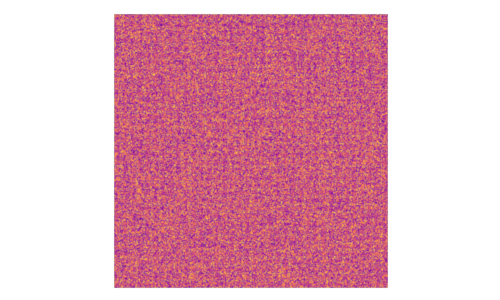

JupyterWgpuCanvas()

In [2]:
# create a `Plot` instance
plot = Plot()

# make some random 2D image data
data = np.random.rand(512, 512)

# plot the image data
plot.add_image(data=data)

# show the plot
plot.show()

### Update image (video)

RFBOutputContext()


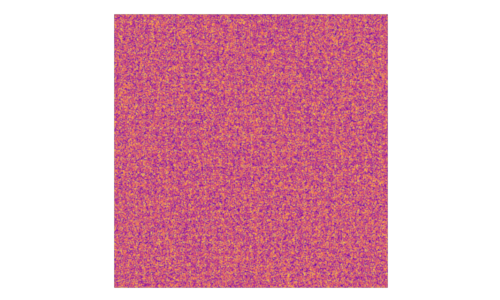

JupyterWgpuCanvas()

In [3]:
# create another `Plot` instance
plot_v = Plot()

# make some random data again
data = np.random.rand(512, 512)

# plot the data, this returns an `ImageGraphic`
image_graphic = plot_v.add_image(data=data)

# a function to update the image_graphic
def update_data():
    new_data = np.random.rand(512, 512)
    image_graphic.data = new_data

#add this as an animation function
plot_v.add_animations(update_data)

# show the plot
plot_v.show()

### We can share controllers across plots

RFBOutputContext()


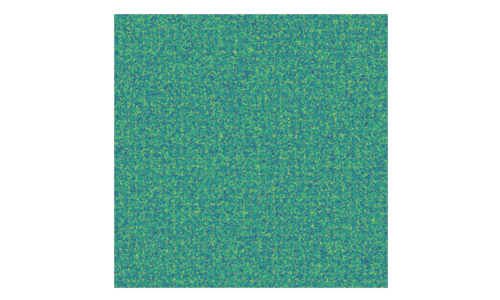

JupyterWgpuCanvas()

In [4]:
plot_sync = Plot(controller=plot_v.controller)

data = np.random.rand(512, 512)
image_2 = plot_sync.add_image(data=data, cmap="viridis")

def update_data_2():
    new_data = np.random.rand(512, 512)
    image_2.data = new_data

plot_sync.add_animations(update_data_2)

plot_sync.show()

### You can also use `ipywidgets.VBox` and `HBox` to stack plots. See the `gridplot` notebooks for a proper gridplot interface for more automated subplotting

In [5]:
VBox([plot_v.show(), plot_sync.show()])

# Please note that `HBox` can be buggy and unstable, avoid using it
This is an upstream issue in `jupyter-rfb`

In [6]:
HBox([plot_v.show(), plot_sync.show()])

### 2D line plot which also shows the color system used for `LineGraphic` and `ScatterGraphic`

In [1]:
from fastplotlib import Plot
from ipywidgets import VBox, HBox
import numpy as np

RFBOutputContext()


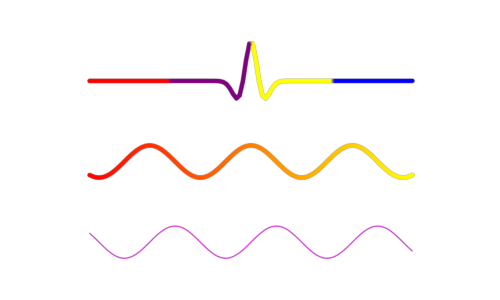

JupyterWgpuCanvas()

In [2]:
plot_l = Plot()

# linspace, create 500 evenly spaced x values from -10 to 10
xs = np.linspace(-10, 10, 100)
# sine wave
ys = np.sin(xs)
sine = np.dstack([xs, ys])[0]


# cosine wave
ys = np.cos(xs) + 5
cosine = np.dstack([xs, ys])[0]

# ricker wavelet
a = 0.5
ys = (2/(np.sqrt(3*a)*(np.pi**0.25))) * (1 - (xs/a)**2) * np.exp(-0.5*(xs/a)**2) * 2 + 10
ricker = np.dstack([xs, ys])[0]

# we can plot multiple things in the same plot
# this is true for any graphic

# plot sine wave, use a single color
plot_l.add_line(data=sine, size=1.5, colors="magenta")

# you can also use colormaps for lines
cosine_graphic = plot_l.add_line(data=cosine, size=5, cmap="autumn")

# or a list of colors for each datapoint
colors = ["r"] * 25 + ["purple"] * 25 + ["y"] * 25 + ["b"] * 25
ricker_graphic = plot_l.add_line(data=ricker, size=5, colors = colors)

plot_l.show()

In [3]:
cosine_graphic.data[10:50:5, :2] = sine[10:50:5]
cosine_graphic.data[90:, 1] = 7

In [18]:
cosine_graphic.data[0] = np.array([[-10, 0, 0]])

In [19]:
ricker_graphic.present

True

In [20]:
ricker_graphic.present = False

In [21]:
def auto_scale(p):
    p.center_scene()
    p.camera.maintain_aspect = False
    width, height, depth = np.ptp(p.scene.get_world_bounding_box(), axis=0)
    p.camera.width = width
    p.camera.height = height

    p.controller.distance = 0
    
    p.controller.zoom(0.8 / p.controller.zoom_value)

In [22]:
auto_scale(plot_l)

In [23]:
ricker_graphic.present = True

In [24]:
auto_scale(plot_l)

## `LineGraphic` and `ScatterGraphic` colors support fancy indexing!

In [25]:
# set the color of the first 250 datapoints, with a stepsize of 3
cosine_graphic.colors[15:50:3] = "cyan"

cosine_graphic.colors[:5] = "magenta"
cosine_graphic.colors[90:] = "yellow"
cosine_graphic.colors[60] = "w"

In [26]:
cosine_graphic.colors[50:, 2] = 1

In [27]:
cosine_graphic.colors[50:, -1] = 0.4

In [28]:
cosine_graphic.colors = "r"

### 3D line plot

RFBOutputContext()

/home/kushal/Insync/kushalkolar@gmail.com/drive/repos/fastplotlib/fastplotlib/layouts/_base.py:142: UserWarning: `center_scene()` not yet implemented for `PerspectiveCamera`
  warn("`center_scene()` not yet implemented for `PerspectiveCamera`")



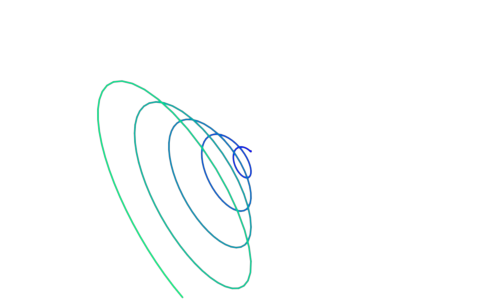

JupyterWgpuCanvas()

In [29]:
# just set the camera as "3d", the rest is basically the same :D 
plot_l3d = Plot(camera='3d')

# create a spiral
phi = np.linspace(0, 30, 200)

xs = phi * np.cos(phi)
ys = phi * np.sin(phi)
zs = phi

# use 3D data
# note: you usually mix 3D and 2D graphics on the same plot
spiral = np.dstack([xs, ys, zs])[0]

plot_l3d.add_line(data=spiral, size=2, cmap='winter')

plot_l3d.show()

### You can combine VBox and HBox to create more complex layouts

This just plots everything above in a single nb output

In [30]:
row1 = HBox([plot.show(), plot_v.show(), plot_sync.show()])
row2 = HBox([plot_l.show(), plot_l3d.show()])

VBox([row1, row2])

NameError: name 'plot' is not defined